In [3]:
import tensorflow as tf
print(tf.__version__)

2.8.2


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Loading and inspecting CIFAR-10 dataset
The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. Here an introduction and a download [link](https://www.cs.toronto.edu/~kriz/cifar.html).


In [4]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Smaller subset of the first 10,000 training images and the first 1,000 test images to speed things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
x_train.shape

(10000, 32, 32, 3)

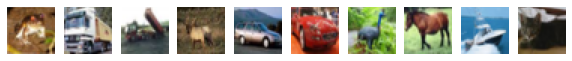

In [ ]:
# Plot the first 10 CIFAR-10 images to check what there is inside

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

Objective is to build a neural network that classifies the images.

Functions to be used

In [ ]:
def get_test_accuracy(model, x_test, y_test):
    """ This function is to test model accuracy on given data.
    Parameters:
     - model
     - x_test
     - y_test """
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    """ This function creates and compiles new instance of a simple CNN. """
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Simple convolutional neural network classifier creation

In [ ]:
# Creating an instance of the model and show model summary to check on it

model = get_new_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-trai

In [ ]:
# Test accuracy of the UNtrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)

accuracy: 0.105


#### Training the model with checkpoints

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)

In [ ]:
# Fit model, with simple checkpoint which saves (and overwrites the file above) model weights every epoch

model.fit(x = x_train,
          y = y_train,
          epochs=3,
          callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - ETA: 0s - loss: 2.0533 - accuracy: 0.2354
Epoch 1: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 11s 35ms/step - loss: 2.0533 - accuracy: 0.2354
Epoch 2/3
312/313 [============================>.] - ETA: 0s - loss: 1.7132 - accuracy: 0.3723
Epoch 2: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 11s 36ms/step - loss: 1.7131 - accuracy: 0.3724
Epoch 3/3
313/313 [==============================] - ETA: 0s - loss: 1.5868 - accuracy: 0.4185
Epoch 3: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 11s 35ms/step - loss: 1.5868 - accuracy: 0.4185


In [ ]:
# Listing data from the directory model_checkpoints

!ls -lh model_checkpoints/

total 184K
-rw-r--r-- 1 root root   77 May 29 15:26 checkpoint
-rw-r--r-- 1 root root 174K May 29 15:26 checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K May 29 15:26 checkpoint.index


checkpoint.data-00000-of-00001 file is the greatest, so there is where data is saved, and the other 2 files are kind of metadata

In [ ]:
# Evaluate the performance of the already trained model this time

get_test_accuracy(model, x_test, y_test)

accuracy: 0.418


Accuracy has increased from above

#### New model, load weights creation

In [ ]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model = get_new_model()
get_test_accuracy(model, x_test, y_test)

accuracy: 0.110


In [ ]:
# Load weights -- accuracy is the same as the trained model

model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.418


#### Directory cleaning

In [ ]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Creation of more customised checkpoint

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object that saves the model weights every 5,000 
# training points with epoch and batch details.

checkpoint_5000_path = 'model_checkpoints_5000/checkpoint_{epoch}_{batch}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                  save_weights_only=True,
                                  save_freq=5000,
                                  verbose=1)

In [ ]:
# Create and fit untrained model with checkpoint

model = get_new_model()
model.fit(x = x_train,
          y = y_train,
          epochs=3,
          validation_data = (x_test, y_test),
          batch_size = 10,
          callbacks = [checkpoint_5000])

Epoch 1/3
1000/1000 [==============================] - 16s 16ms/step - loss: 1.8314 - accuracy: 0.3196 - val_loss: 1.5781 - val_accuracy: 0.4350
Epoch 2/3
1000/1000 [==============================] - 18s 18ms/step - loss: 1.5139 - accuracy: 0.4521 - val_loss: 1.4625 - val_accuracy: 0.4850
Epoch 3/3
1000/1000 [==============================] - 18s 18ms/step - loss: 1.4179 - accuracy: 0.4915 - val_loss: 1.4190 - val_accuracy: 0.4890


In [ ]:
# Have a look at what the checkpoint creates
!ls -lh model_checkpoints_5000

ls: cannot access 'model_checkpoints_5000': No such file or directory


#### Work with model saving criteria

In [ ]:
# Use tiny training and test set (100 pictures in each) -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [ ]:
# Create a new instance of untrained model

model = get_new_model()

In [ ]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoints'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [ ]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(x = x_train,
                    y = y_train,
                    epochs=50,
                    validation_data=(x_test, y_test),
                    batch_size=10,
                    callbacks=[checkpoint_best],
                    verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.13000, saving model to model_checkpoints_best/checkpoints

Epoch 2: val_accuracy did not improve from 0.13000

Epoch 3: val_accuracy improved from 0.13000 to 0.14000, saving model to model_checkpoints_best/checkpoints

Epoch 4: val_accuracy did not improve from 0.14000

Epoch 5: val_accuracy did not improve from 0.14000

Epoch 6: val_accuracy improved from 0.14000 to 0.15000, saving model to model_checkpoints_best/checkpoints

Epoch 7: val_accuracy did not improve from 0.15000

Epoch 8: val_accuracy did not improve from 0.15000

Epoch 9: val_accuracy did not improve from 0.15000

Epoch 10: val_accuracy did not improve from 0.15000

Epoch 11: val_accuracy did not improve from 0.15000

Epoch 12: val_accuracy did not improve from 0.15000

Epoch 13: val_accuracy did not improve from 0.15000

Epoch 14: val_accuracy improved from 0.15000 to 0.16000, saving model to model_checkpoints_best/checkpoints

Epoch 15: val_accuracy did not improve from 0

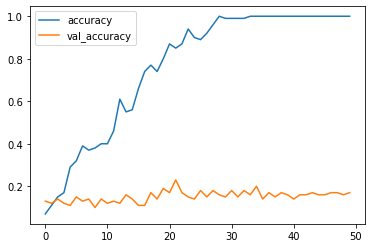

In [ ]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [ ]:
# Inspect the checkpoint directory

! ls -ls model_checkpoints_best/

total 184
  4 -rw-r--r-- 1 root root     79 May 29 15:37 checkpoint
176 -rw-r--r-- 1 root root 178037 May 29 15:37 checkpoints.data-00000-of-00001
  4 -rw-r--r-- 1 root root   2038 May 29 15:37 checkpoints.index


In [ ]:
# Create a new model with the saved weights

new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)

accuracy: 0.230


#### Clear directory

In [ ]:
! rm -r model_checkpoints_5000 model_checkpoints_best

rm: cannot remove 'model_checkpoints_5000': No such file or directory
rm: cannot remove 'model_checkpoints_best': No such file or directory


***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             frequency='epoch',
                             verbose=1)

In [ ]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x = x_train,
          y = y_train,
          epochs = 3,
          callbacks=[checkpoint])

Epoch 1/3
313/313 [==============================] - ETA: 0s - loss: 1.9402 - accuracy: 0.2930
Epoch 1: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
313/313 [==============================] - 11s 34ms/step - loss: 1.9402 - accuracy: 0.2930
Epoch 2/3
313/313 [==============================] - ETA: 0s - loss: 1.5869 - accuracy: 0.4287
Epoch 2: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
313/313 [==============================] - 11s 35ms/step - loss: 1.5869 - accuracy: 0.4287
Epoch 3/3
311/313 [============================>.] - ETA: 0s - loss: 1.4487 - accuracy: 0.4853
Epoch 3: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
313/313 [==============================] - 11s 34ms/step - loss: 1.4490 - accuracy: 0.4851


#### Inspect what the checkpoint has created

In [ ]:
# Have a look at what the checkpoint creates

!ls -ls model_checkpoints/

total 144
  4 drwxr-xr-x 2 root root   4096 May 29 16:44 assets
 16 -rw-r--r-- 1 root root  13885 May 29 16:44 keras_metadata.pb
120 -rw-r--r-- 1 root root 119201 May 29 16:44 saved_model.pb
  4 drwxr-xr-x 2 root root   4096 May 29 16:44 variables


In [ ]:
# saved_model.pb --> contains model architecture and hot to put the weights back into the model

# Enter variables directory
!ls -ls model_checkpoints/variables/ # weights are saved here

total 184
180 -rw-r--r-- 1 root root 182160 May 29 16:44 variables.data-00000-of-00001
  4 -rw-r--r-- 1 root root   2251 May 29 16:44 variables.index


In [ ]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.490


#### Create new model from scratch

In [ ]:
# Delete model

del model

In [ ]:
# Check that it is effectively deleted

model

NameError: ignored

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Reload model from scratch

model = load_model(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.490


Same accuracy as the previous model, which is normals since the architecture of the first model has been loaded for this second one.

#### Use the .h5 format to save model

In [ ]:
# Save the model in .h5 format

model.save('mymodel.h5')

In [ ]:
# Inspect .h5 file

!ls -lh mymodel.h5

-rw-r--r-- 1 root root 78K May 29 16:53 mymodel.h5


This is not a deirectory, only a single file.

In [ ]:
# Delete model

del model

In [ ]:
model

NameError: ignored

In [ ]:
# Reload model from scratch

model = load_model('mymodel.h5')
get_test_accuracy(model, x_test, y_test)

accuracy: 0.490


#### Clear directory

In [ ]:
! rm -r model_checkpoints
! rm mymodel.h5

rm: cannot remove 'model_checkpoints': No such file or directory


***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

ResNet50 model was designed by a team at Microsoft Research, available through Keras applications. Description is available on the [Keras applications page](https://keras.io/applications/#resnet) for details. To cite it properly, the paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

To import it:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In [ ]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
# Build Keras ResNet50 model

#model = load_model('model/Keras_RestNet50.h5')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### Import and preprocess 3 sample images

In [ ]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('drive/MyDrive/Coursera/GettingStartedTensorFlow2/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('drive/MyDrive/Coursera/GettingStartedTensorFlow2/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('drive/MyDrive/Coursera/GettingStartedTensorFlow2/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [ ]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

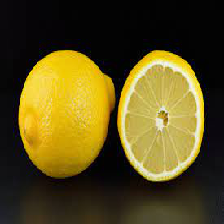

In [ ]:
# Display image
lemon_img

In [ ]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)

49152/35363 [=========================================] - 0s 0us/step


,prediction,probability
1,lemon,0.996911
2,orange,0.002756
3,yellow_lady's_slipper,0.000188
4,tennis_ball,0.000034
5,jackfruit,0.00002


##### Image 2: viaduct

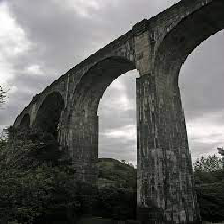

In [ ]:
# Display image
viaduct_img

In [ ]:
# Display top 5 predictions
get_top_5_predictions(viaduct_img)

,prediction,probability
1,viaduct,0.998197
2,pier,0.000973
3,triumphal_arch,0.000233
4,suspension_bridge,0.000209
5,steel_arch_bridge,0.000164


##### Image 3: water tower

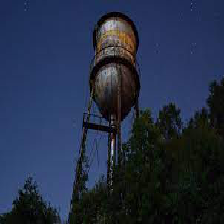

In [ ]:
# Display image
water_tower_img

In [ ]:
# Display top 5 predictions
get_top_5_predictions(water_tower_img)

,prediction,probability
1,water_tower,0.993302
2,beacon,0.001173
3,missile,0.000816
4,spotlight,0.000544
5,balloon,0.000508


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Using Google's MobileNet v1 model, available on Tensorflow Hub.Description is available on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. To cite it properly, the paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

To import it locally, use the following code:

```python
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
```

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [ ]:
# Build Google's Mobilenet v1 model
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

In [ ]:
from tensorflow.python.tools import module_util
# Build Google's Mobilenet v1 model

#model = load_model('models/TensorFlow_MobilNet_v1')
model = Sequential(hub.KerasLayer(module_url))
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              1343049   
                                                                 
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [ ]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("drive/MyDrive/Coursera/GettingStartedTensorFlow2/lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("drive/MyDrive/Coursera/GettingStartedTensorFlow2/viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("drive/MyDrive/Coursera/GettingStartedTensorFlow2/water_tower.jpg", target_size=(160, 160))

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-05-29 18:26:11--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-05-29 18:26:12 (77.0 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [ ]:
# Read in categories text file

with open('imagenet_classes.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [ ]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

In [ ]:
get_top_5_predictions(lemon_img)

,prediction
1,fig
2,lemon
3,acorn squash
4,lumbermill
5,photocopier


##### Image 2: viaduct

In [ ]:
get_top_5_predictions(viaduct_img)

,prediction
1,violin
2,steel drum
3,piggy bank
4,swab
5,microphone


##### Image 3: water tower

In [ ]:
get_top_5_predictions(water_tower_img)

,prediction
1,whiskey jug
2,tow truck
3,book jacket
4,ballpoint
5,bib
